# Exercise B: Hidden Markov Models

We consider a first order Markov chain where the variables are binary, $x_i \in \{0,1\}$, $i = 1,...,n$, with stationary probabilities $p(x_{i+1} = l|x_i = k) = P(k,l)$. These onestep probabilities can be organized as a Markov transition matrix
\begin{equation*}
\left[{\begin{array}{cc}
P(0,0) & P(0,1) \\
P(1,0) & P(1,1)
\end{array}}\right], \enspace \sum\limits_{l=0}^1 P(0,l) = 1, \enspace \sum\limits_{l=0}^1 P(1,l) = 1.
\end{equation*}
The marginal pdf for x_1 must also be specified to complete the model formulation.

Data $\bf{y} = (y_1,...,y_n)$ are conditionally independent, given the variable of interest, and the Gaussian likelihood is defined by $p(y_i|x_i) = \mathcal{N}(x_i,\tau^2), i = 1,...n,$. 

## a.
We are to simulate a Markov chain of length $N = 250$ with equal dependence: $P(0,0) = P(1,1) = p$, $p(x_1 = 1) = 0.5$, and we set $p=0.9$.


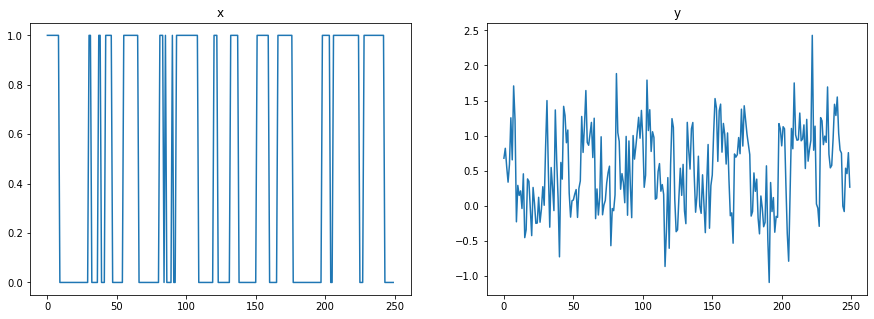

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(1)
p = 0.9
p_init = 0.5
N = 250
x = np.zeros(N)
y = np.zeros(N)
x[0] = (np.random.rand()<p_init)*1
y[0] = x[0] + np.random.normal(0,0.4)
for i in range(1,N):
    if np.random.rand()<= p:
        x[i] = x[i-1]
    else:
        x[i] = 1-x[i-1]
    y[i] = x[i] + np.random.normal(0,0.4)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(x)
plt.title("x")
plt.subplot(122)
plt.plot(y)
plt.title("y")
plt.show()

The left plot shows the Markov chain, $\mathbf{x}$, and the right plot shows the observations, $\mathbf{y}$. 

## b.
$p$ is the probability that the hidden Markov chain to stay in the same state i.e. $P(0,0)=P(1,1) = p$, and $\tau$ is the standard deviation of the likelihood $p(y_i|x_i) = N(x_i|\tau^2)$. We want to find the maximum likelihood estimates of $p$ and $\tau$. First we will explain how we find the marginal likelihood $p(\mathbf{y})$ by the forward recursion algorithm. The joint posterior marginal is calculated by 
\begin{equation*}
\begin{array}{rcl}
p(\mathbf{y}) &=& \prod\limits_{i=2}^N p(y_i|\mathbf{y}_{1:i-1}) \\
& = & \prod\limits_{i=2}^N \sum\limits_{k = 0}^1 \sum\limits_{l = 0}^1  p(x_i = k|x_{i-1} = l) p(y_i|x_i = k , \mathbf{y}_{1:i-1}),
\end{array}
\end{equation*}
but this calculation becomes computationally difficult because of $O(2^N)$. Instead we use the forward algorithm which has computational efficiency $O(2^2N)$. 
We define $\alpha_i(k) \equiv p(\mathbf{y}_{1:i},x_i = k)$, where $i \in [1,250]$ and $k\in\{0,1\}$ is the state. The initialization is given by $\alpha_1(k) = p(y_1|x_1 = k)p(x_1 = k)$, after which the recursion is given by 
\begin{equation*}
\begin{array}{rcl}
\alpha_i(k) &=& \sum\limits_{l=0}^1 p(\mathbf{y}_{1:i}, x_i = k, x_{i-1} = l)\\
& = & \sum\limits_{l=0}^1 p(y_i|x_i = k)p(x_i = k|x_{i-1} = l)p(\mathbf{y}_{1:i-1}|x_{i-1} = l) \\ 
& = & p(y_i|x_i = k)\sum\limits_{l=0}^1 P(l,k)\alpha_{i-1}(l).
\end{array}
\end{equation*}

This yields the iterative marginal likelihood by 
\begin{equation*}
p(\mathbf{y}_{1:i}) = \sum\limits_{k=0}^1 \alpha_i(k).
\end{equation*}

In [0]:
def forward(y,p,tau):
    alpha = np.zeros((2,y.size))
    m_like = np.zeros(y.size)
    # setting init state probs
    alpha[0,0] = 0.5*norm.pdf(y[0],0,tau)
    alpha[1,0] = 0.5*norm.pdf(y[0],1,tau)
    m_like[0] = np.sum(alpha[:,0])
    for i in range(1,N):
        for k in range(2):
            alpha[k,i] = norm.pdf(y[i],k,tau)*(alpha[k,i-1]*p+alpha[1-k,i-1]*(1-p))
        m_like[i] = np.sum(alpha[:,i])
    return m_like[y.size-1]

def max_like(y):
    p_vec = np.linspace(0,1,11)
    tau_vec = np.linspace(0.1,1,10)
    tmp = 0
    tmp_max = 0
    max_val = np.zeros(2)
    for p in p_vec:
        for tau in tau_vec:
            tmp = forward(y,p,tau)
            if tmp > tmp_max:
                tmp_max = tmp
                max_val = [p,tau]
    return max_val

max_like_est = max_like(y)
max_like_est

[0.9, 0.4]

# c.
To use the forward-backward recursion, we need to first create the algorithm for backward recursion. We want to calculate $\beta_i(k) \equiv p(\mathbf{y}_{i:N}|x_i = k)$, which is the recursive steps. The initial state is set to $\beta_N(k) = 1$, and the recursion yields the equation $\beta_i(k) = \sum\limits_{l=0}^1 P(k,l) p(y_{i+1}|x_{i+1}=l)\beta_{i+1}(l)$.

We want to find the probability that the hidden sequence has state $1$ at step $i$, which is given by the equation
\begin{equation*}
\begin{array}{rcl}
p(x_i = 1|\mathbf{y}) &= & \frac{p(\mathbf{y}|x_i = 1)p(x_i = 1)}{p(\mathbf{y})}\\
&=&\frac{p(\mathbf{y}_{1:i}|x_i = 1)p(\mathbf{y}_{i+1:N}|x_i = 1)p(x_i = 1)}{\sum\limits_{k=0}^1 p(x_i=k, \mathbf{y})} \\ 
&=&\frac{\alpha_i(1)\beta_i(1)}{\sum\limits_{k = 0}^1 \alpha_i(k)\beta_i(k)}
\end{array}
\end{equation*}

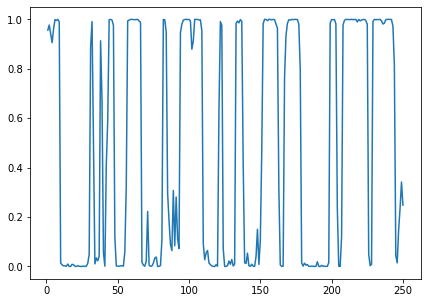

In [0]:
def forward(y,p,tau):
    alpha = np.zeros((2,y.size))
    alpha[:,0] = [0.5*norm.pdf(y[0],0,tau),0.5*norm.pdf(y[1],1,tau)]
    for i in range(1,N):
        for k in range(2):
            alpha[k,i] = norm.pdf(y[i],k,tau)*(alpha[k,i-1]*p+alpha[1-k,i-1]*(1-p))
    return alpha

def backward(y,p,tau):
    beta = np.zeros((2,y.size))
    beta[:,y.size-1] = [1,1]
    for i in range(y.size-2,-1,-1):
        for k in range(2):
            beta[k,i] = beta[k,i+1]*p*norm.pdf(y[i+1],k,tau) + beta[1-k,i+1]*(1-p)*norm.pdf(y[i+1],1-k,tau)
    return beta
    

def forward_backward(y,p,tau):
    alpha = forward(y,p,tau)
    beta = backward(y,p,tau)
    marg_prob = np.zeros(y.size)
    for i in range(y.size):
        marg_prob[i] = alpha[1,i]*beta[1,i]/np.dot(alpha[:,i],beta[:,i])
    return marg_prob
     
state_prob = forward_backward(y,max_like_est[0],max_like_est[1])
plt.figure(figsize=(7, 5))
plt.plot(np.linspace(1,y.size,y.size),state_prob)

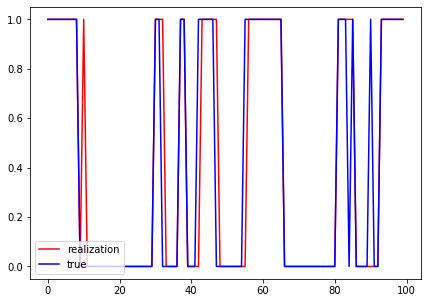

In [0]:
def r_mc(fb_prob,N):
    res = np.zeros(N)
    for i in range(N):
        if np.random.rand()<=fb_prob[i]:
            res[i] = 1
        else:
            res[i] = 0
    return res

x_rel = r_mc(state_prob,100)
plt.figure(figsize=(7, 5))
plt.plot(x_rel,'r',x[0:100],'b')
plt.legend(["realization","true"],loc= "lower left")

# d.

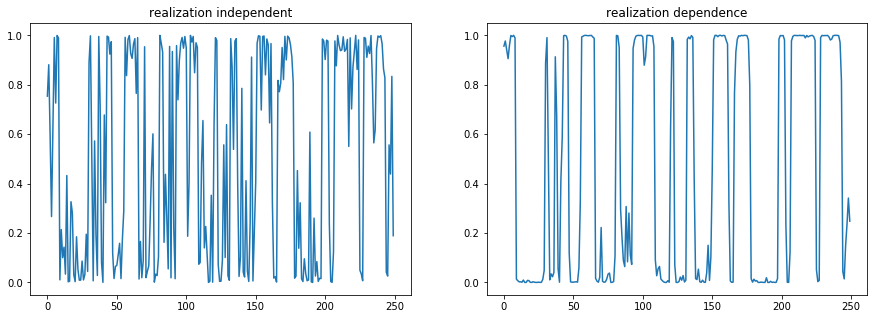

In [0]:
def strict_mc(y,tau):
    marg_prob = np.zeros(y.size)
    for i in range(y.size):
        marg_prob[i] = norm.pdf(y[i],1,tau)/(norm.pdf(y[i],0,tau) + norm.pdf(y[i],1,tau))
    return marg_prob

strict_state_prob = strict_mc(y,0.4)


plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(strict_state_prob)
plt.title("realization independent")
plt.subplot(122)
plt.plot(state_prob)
plt.title("realization dependence")
plt.show()

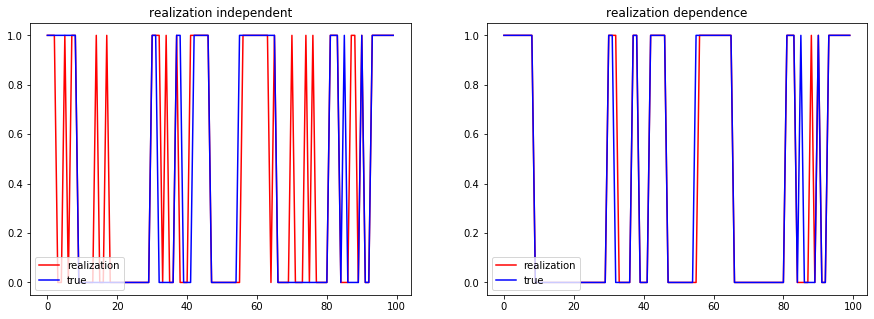

In [0]:
np.random.seed(123)
x_rel2 = r_mc(strict_state_prob,100)


plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(x_rel2,'r',x[0:100],'b')
plt.title("realization independent")
plt.legend(["realization","true"],loc= "lower left")
plt.subplot(122)
plt.plot(x_rel,'r',x[0:100],'b')
plt.title("realization dependence")
plt.legend(["realization","true"],loc= "lower left")